In [0]:
import PIL
from PIL import Image
import glob, os
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image as pil
import scipy.io
from google.colab import drive
from scipy.spatial import distance
drive.mount('/content/drive')
import cv2
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# 1. Download the dataset and understand the format

In [0]:
trainimgdir="/content/drive/My Drive/Colab Notebooks/data/images/train"
grdimgdir="/content/drive/My Drive/Colab Notebooks/data/groundTruth/train"
data=[]
groundTruth=[]

for image in sorted(os.listdir(trainimgdir)):
  img=os.path.join(trainimgdir,image)
  data.append(np.array(pil.open(img)))

for truth in sorted(os.listdir(grdimgdir)):
  t=os.path.join(grdimgdir,truth)
  groundTruth.append(scipy.io.loadmat(t))

train_img=np.array(data)
train_gt=np.array(groundTruth)

print(train_img.shape)
print(train_gt.shape)

(200,)
(200,)


# 2. Visualize the image and the ground truth segmentation

(321, 481, 3)


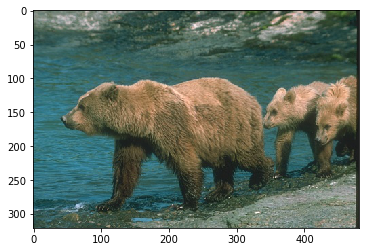

In [0]:
img_no = 0
plt.imshow(train_img[img_no])
print(train_img[img_no].shape)
plt.show()

All image segments: 


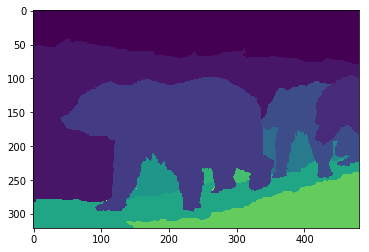

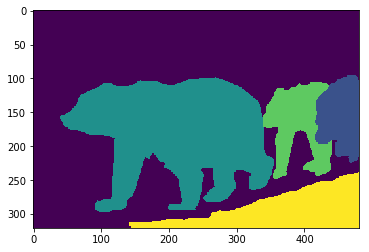

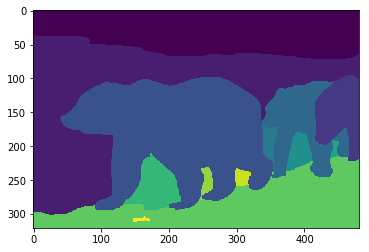

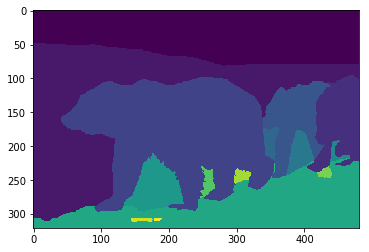

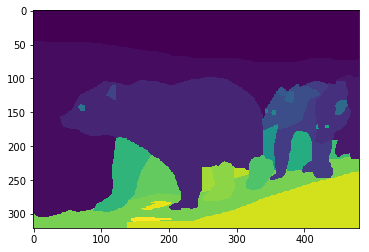

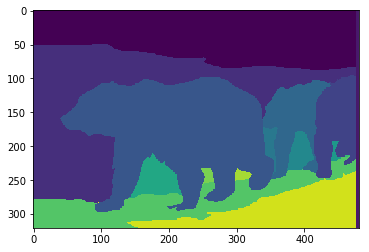

(321, 481)


In [0]:

gt_labels = groundTruth[img_no]["groundTruth"][0][0][0][0][0]

gt_mat = groundTruth[img_no]["groundTruth"]
num_segments = gt_mat[0].size
seg_img = gt_mat[0][0]['Segmentation'][0][0]

print('All image segments: ')
for i in range(0,num_segments):
  plt.imshow(gt_mat[0][i]['Segmentation'][0][0])
  plt.show()
  
print(gt_mat[0][0]['Segmentation'][0][0].shape)


## Preprocessing

In [0]:
vectorized=[]
Blur_train_img=[]
# make image smoother
data_img=cv2.GaussianBlur(train_img[img_no],(7,7),0)
print(train_img[img_no].shape)

vector=data_img.reshape(-1,3)
print(vector.shape)
vectorized.append(vector)


vec_train_img=np.array(vectorized)
print(vec_train_img.shape)

(321, 481, 3)
(154401, 3)
(1, 154401, 3)


# 3. Segmentation using K-means

for k = 3


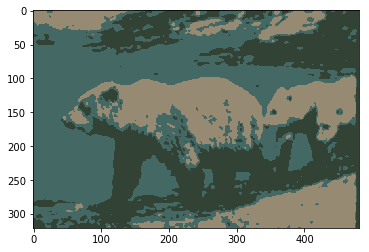

for k = 5


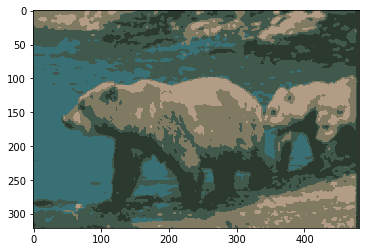

for k = 7


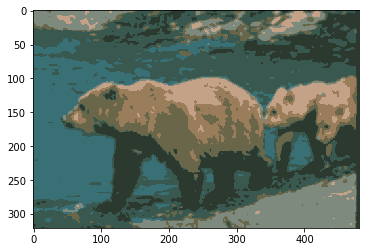

for k = 9


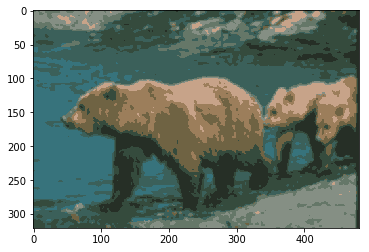

for k = 11


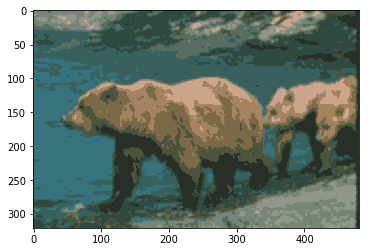

In [0]:
k = [3,5,7,9,11]
for i in k:
  kmeans = KMeans(n_clusters=i).fit(vector)
  rec_img=kmeans.cluster_centers_[kmeans.labels_]
  seg_im = rec_img.reshape(data_img.shape)
  print('for k =',i)
  plt.imshow((seg_im/255))
  plt.show()

In [0]:
from sklearn.metrics.cluster import contingency_matrix
kmeans_labels = kmeans.labels_
gt_labels = gt_labels.flatten()

print(max(gt_labels))
print(max(kmeans_labels))
cont = contingency_matrix(gt_labels, kmeans_labels)
print(gt_labels.size)
print(kmeans_labels.size)

18
10
154401
154401


### F-measure implementation

In [0]:
#f measure

contingency = cont.T
print('contingency',contingency)
sum_cols = np.sum(contingency,axis=0)
sum_rows = np.sum(contingency,axis =1)
# print(sum_cols ,sum_rows)
prec = np.array([])
recall = np.array([])

count = 0
for i in contingency:

    prec = np.append(prec,(max(i)/sum_rows[count]))
    recall = np.append(recall,(max(i)/sum_cols[np.argmax(i)]))

    count+=1

f1_measure = (2*prec *recall)/(prec+recall)
total_f1_measure = (1/len(f1_measure))* np.sum(f1_measure)
print('total f score: ',total_f1_measure)

contingency [[ 5691  1234    49    94    31     0   109     0     0     2   894     0
      0  1249     0     0     0     0]
 [10978  2818    17  1753   671     0    49   168   112   216  6462    42
    133    75     6     0     0     2]
 [ 2468    31    63   392   177     0     0     0     0     0    53     0
      0  4232     0     0     0     0]
 [ 1789   141   252  8652  3559     0     2     5     0     5  1228     0
      2   208     0     0     1     0]
 [   58     0   985 10436   807     0     2     0     0     0    36     0
      0     0     0     0     0     0]
 [  729     0  1124  3404  1710     0     0     0     0     0     0     0
      0    12     0     0     0     0]
 [ 3424 16664     0   139    53     0   456  1132   120  1615  2628   175
    264    14     0     1     0     0]
 [    3 16997     0     2     0     0   267   298     0   939   492    82
      0     6     0     0     0     0]
 [   18     4  1779  6321  1095     1     0     0     0     0     0     0
      0   

### Conditional Entropy implementation

In [0]:
#conditional entropy

values = np.array([])
c = 0
for i in range(len(contingency)):
    for j in range(len(contingency.T)):
        values = np.append(values,contingency[i][j]/sum_rows[c])
    c+=1

entropy = np.array([])

for i in values:
    if i==0 or i==1:
        entropy = np.append(entropy,0)
    else:
        entropy = np.append(entropy,-i*np.log2(i))

entropy = entropy.reshape(contingency.shape)

# print(entropy)
total_entropy = np.array([])
c= 0
for i in entropy:
    total_entropy = np.append(total_entropy, (sum_rows[c]/np.sum(sum_cols))*np.sum(i))
    c+=1
#     print(np.sum(i))
# print('tot=',total_entropy) 
total_entropy =np.sum(total_entropy)

print('conditional entropy=',total_entropy)




conditional entropy= 1.5946707113518275


# 4. Big Picture

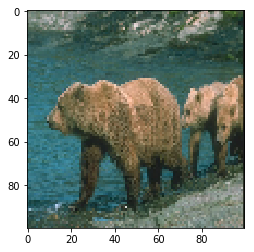

(100, 100, 3)
(10000, 3)
(2,)


In [0]:
#spectral clustering

img_no=0
im = pil.fromarray(train_img[img_no].astype('uint8'))
res = cv2.resize(train_img[img_no], dsize=(100, 100), interpolation=cv2.INTER_CUBIC)
plt.imshow(res)
# print(res.shape)
plt.show()

# make image smoother
data_img=cv2.GaussianBlur(res,(7,7),0)
print(res.shape)


# unrolled=data_img.reshape(-1,3)
unrolled=data_img.reshape(-1,3)
print(unrolled.shape)
vectorized.append(unrolled)


vec_train_img=np.array(vectorized)
print(vec_train_img.shape)


[[ 0.          1.73205081  5.38516481 ... 10.09950494 16.97056275
  25.25866188]
 [ 1.73205081  0.          3.74165739 ... 11.         15.58845727
  23.68543856]
 [ 5.38516481  3.74165739  0.         ... 14.17744688 14.03566885
  21.28379665]
 ...
 [10.09950494 11.         14.17744688 ...  0.         18.49324201
  27.74887385]
 [16.97056275 15.58845727 14.03566885 ... 18.49324201  0.
   9.2736185 ]
 [25.25866188 23.68543856 21.28379665 ... 27.74887385  9.2736185
   0.        ]]
(100000000,)


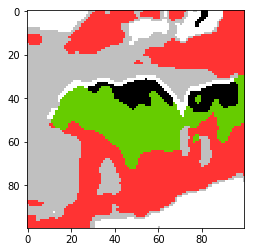

In [0]:
from sklearn.metrics import pairwise_distances
distance_matrix= pairwise_distances(unrolled, metric='euclidean')
print(distance_matrix)

affinity = []
for row in distance_matrix:
  for d in row:
    aff= np.exp(-0.01 * d ** 2)
    affinity.append(aff)

affinity=np.array(affinity)
print(affinity.shape)

from sklearn.cluster import SpectralClustering
affinity=affinity.reshape(10000,10000)
clustering = SpectralClustering(n_clusters=5, assign_labels="discretize", affinity="precomputed").fit(affinity)

colors = [[192,192,192],[0,0,0],[255,255,255],[255,51,51],[102,204,0],[0,255,255],[96,96,96],[51,51,255],[204,255,255],[200,200,200],[100,100,100]]
newImage = []
for k in range(0,10000):
  newImage.append(colors[clustering.labels_[k]])
  
newImage=np.array(newImage).reshape(100,100,3)
plt.imshow(newImage)


In [0]:
#assign_labels = discritized

from sklearn.cluster import SpectralClustering
affinity=affinity.reshape(10000,10000)
clustering = SpectralClustering(n_clusters=5, assign_labels="discretize", affinity="precomputed").fit(affinity)

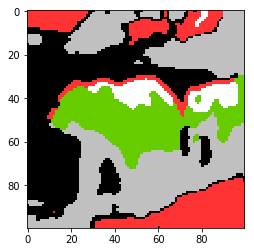

In [0]:
colors = [[192,192,192],[0,0,0],[255,255,255],[255,51,51],[102,204,0],[0,255,255],[96,96,96],[51,51,255],[204,255,255],[200,200,200],[100,100,100]]
newImage = []
for k in range(0,10000):
  newImage.append(colors[clustering.labels_[k]])
  
newImage=np.array(newImage).reshape(100,100,3)
plt.imshow(newImage)


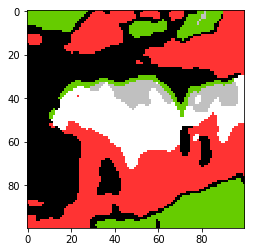

In [0]:
#Assign_Labels = kmeans

clustering = SpectralClustering(n_clusters=5, assign_labels="kmeans", affinity="precomputed",n_neighbors=5).fit(affinity)

colors = [[192,192,192],[0,0,0],[255,255,255],[255,51,51],[102,204,0],[0,255,255],[96,96,96],[51,51,255],[204,255,255],[200,200,200],[100,100,100]]
newImage = []
for k in range(0,10000):
  newImage.append(colors[clustering.labels_[k]])
  
newImage=np.array(newImage).reshape(100,100,3)
plt.imshow(newImage)

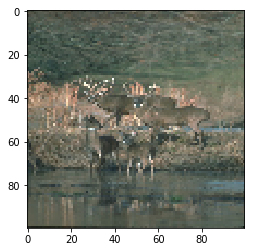

In [0]:

from sklearn.neighbors import NearestNeighbors
for i in range(0,5):
  im = pil.fromarray(train_img[i].astype('uint8'))
  res = cv2.resize(train_img[i], dsize=(100, 100), interpolation=cv2.INTER_CUBIC)
plt.imshow(res)


#Bonus

In [0]:

img=res

features=[]
for i in range(100):
  for j in range(100):
    r=res[i][j][0]
    g=res[i][j][1]
    b=res[i][j][2]
    result= [i,j,r,g,b]
    features.append(result)
        
features = np.array(features)
print(features.shape)



(10000, 5)


In [0]:
print("    X   Y   R   G   B")
print(features)

    X   Y   R   G   B
[[  0   0 102 116  98]
 [  0   1 126 132 118]
 [  0   2 121 133 122]
 ...
 [ 99  97 161 161 158]
 [ 99  98 148 158 149]
 [ 99  99  47  43  36]]


for k = 3


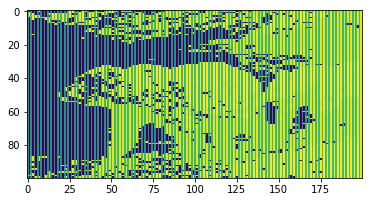

for k = 5


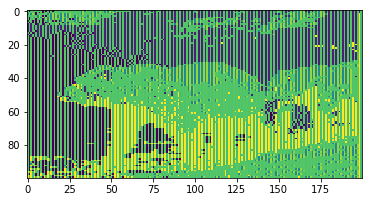

for k = 7


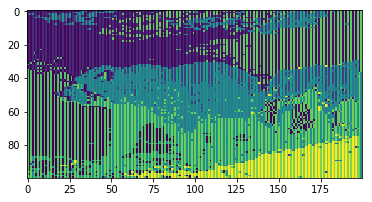

for k = 9


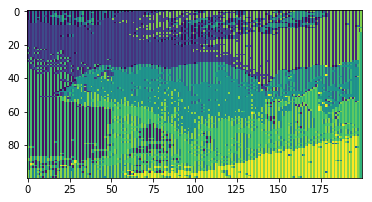

for k = 11


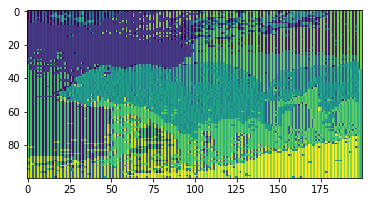

In [0]:
k = [3,5,7,9,11]
for i in k:
  kmeans = KMeans(n_clusters=i).fit(features)
  rec_img=kmeans.cluster_centers_[:,0:2][kmeans.labels_]
  seg_im = rec_img.reshape(100,200)
  print('for k =',i)
  plt.imshow((seg_im/255))
  plt.show()
  